# Signal Generation

Xây dựng tín hiệu dự đoán xu hướng giá gồm:
- *OrderBook Signal*: dự đoán xu hướng thị trường (data Orderbook - SVM)
- *Mean Revertion Signal*: kết hợp các đặc trưng của Mean Reversion (data OHLC - LSTM)

## Import module

In [ ]:
! pip install kaggle
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn import svm
import pickle
from sklearn.preprocessing import StandardScaler
import csv
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')







## Generate Label (Signal)

Tự gán nhãn tín hiệu bằng cách sử dụng dữ liệu OHLC. So sánh giá đóng cửa hiện tại với giá đóng cửa sau 5 khoảng thời gian với ngưỡng $\epsilon = 5.10^{-4}$  
- Lớp 1: go up
- Lớp -1: go down (chuyển thành 2 để phù hợp với output của mô hình máy học)
- Lớp 0: side way

### For OHLC data

In [ ]:
df_ohc = pd.read_csv('/content/openhighclose_ETHUSDT_7d.csv')
df_ohc['start_at'] = pd.to_datetime(df_ohc['start_at'], unit='s')

In [ ]:
# Tạo Signal

delta = 0.0005  # Ngưỡng
# Time span for future price comparison
time_span = 5

df_ohc['signal'] = 0 # sideway
df_ohc.loc[df_ohc['close'].shift(-time_span) > df_ohc['close'] * (1 + delta), 'signal'] = 1 # go up
df_ohc.loc[df_ohc['close'].shift(-time_span) < df_ohc['close'] * (1 - delta), 'signal'] = 2 # go down

# df_ohc.dropna(subset=['signal'], inplace=True)
# eth close price 2024-01-08 00:00:00 is 2220.77
df_ohc.loc[10079, 'signal'] = 2

In [ ]:
# only get data from the 1st day to the 7th day
df_ohc.drop(df_ohc.loc[df_ohc['start_at'] > '2024-01-08 00:00:00'].index, inplace=True)

In [ ]:
df_ohc['signal'].value_counts()

,count
signal,
0,3609
1,3311
2,3161


In [ ]:
# export file for Streamlit app
df_ohc.to_csv("processed_ohc_df.csv", index=False)

### For Order Book data

In [ ]:
df = pd.read_csv('/content/orderbook_ETHUSDT_7d.csv', index_col=False)

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,bid_price_3,bid_size_3,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00.631,2283.88,2.38,2283.87,29.44,2283.89,0.1,2283.86,2.1,2283.92,0.34,2283.84,13.08,2283.93,29.08,2283.83,3.6,2284.04,4.38,2283.8,2.31
2024-01-01 00:00:00.729,2283.88,2.38,2283.87,22.94,2283.89,0.1,2283.86,2.1,2283.92,0.34,2283.84,13.08,2283.93,29.08,2283.83,3.6,2284.04,4.38,2283.8,2.31
2024-01-01 00:00:00.829,2283.88,2.38,2283.87,22.94,2283.89,0.1,2283.86,2.1,2283.92,0.34,2283.84,13.08,2283.93,29.08,2283.83,3.6,2284.04,4.38,2283.8,2.31
2024-01-01 00:00:00.929,2283.88,2.38,2283.87,22.94,2283.89,0.1,2283.86,2.1,2283.92,0.34,2283.84,13.08,2283.93,29.08,2283.83,3.6,2284.04,4.38,2283.8,2.31
2024-01-01 00:00:01.029,2283.88,2.38,2283.87,29.44,2283.89,0.1,2283.86,2.1,2283.92,0.34,2283.84,13.08,2283.93,29.08,2283.83,3.6,2284.04,4.38,2283.8,2.31


Resampling In Order To Have A Uniform Temporal Grid

In [ ]:
resampled_df = df.resample('60s').last().ffill()
resampled_df.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,bid_price_3,bid_size_3,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5
timestamp,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,2284.01,2.32,2284.00,37.17,2284.02,0.10,2283.99,0.1,2284.10,1.56,2283.92,2.13,2284.11,2.53,2283.89,9.49,2284.20,2.10,2283.88,15.10
2024-01-01 00:01:00,2285.89,12.41,2285.88,16.58,2285.91,18.93,2285.87,3.6,2285.93,0.30,2285.80,2.97,2285.94,0.20,2285.79,5.08,2285.95,11.31,2285.76,18.96
2024-01-01 00:02:00,2286.29,33.21,2286.28,50.32,2286.30,0.11,2286.27,0.1,2286.34,0.22,2286.25,5.50,2286.36,11.71,2286.24,8.02,2286.39,1.31,2286.23,22.86
2024-01-01 00:03:00,2288.31,1.31,2288.30,71.18,2288.32,0.10,2288.29,0.1,2288.33,30.56,2288.28,15.00,2288.37,0.01,2288.25,2.00,2288.38,0.01,2288.24,18.74
2024-01-01 00:04:00,2289.98,26.53,2289.97,25.60,2289.99,33.31,2289.96,0.1,2290.00,34.27,2289.90,10.31,2290.01,0.95,2289.89,3.60,2290.02,2.47,2289.88,11.67


In [ ]:
df = resampled_df.copy()

# add the 'signal' column from df_ohc to df
df['signal'] = df_ohc['signal'].values

In [ ]:
df['signal'].value_counts()

,count
signal,
0,3609
1,3311
2,3161


## Building Model

### Model for Mean Reversion Signal

#### Prepare Data

In [ ]:
df_ohc.head()

,start_at,symbol,period,open,high,low,close,signal
0,2024-01-01 00:00:00,ETHUSD,1,2281.49,2282.48,2280.88,2281.45,1
1,2024-01-01 00:01:00,ETHUSD,1,2281.45,2283.51,2281.43,2283.37,1
2,2024-01-01 00:02:00,ETHUSD,1,2283.37,2284.21,2283.08,2284.02,1
3,2024-01-01 00:03:00,ETHUSD,1,2284.02,2285.88,2284.01,2285.85,1
4,2024-01-01 00:04:00,ETHUSD,1,2285.85,2287.39,2285.65,2287.29,1


In [ ]:
# Calculate indicators (mean reversion)
df_ohc['EMA_12'] = df_ohc['close'].ewm(span=12, adjust=False).mean()
df_ohc['EMA_26'] = df_ohc['close'].ewm(span=26, adjust=False).mean()
df_ohc['EMA_50'] = df_ohc['close'].ewm(span=50, adjust=False).mean()
# Tạo dữ liệu trễ cho các bước thời gian trước đó
for lag in range(1, 3):
    df_ohc[f'close_lag_{lag}'] = df_ohc['close'].shift(lag)

df_ohc['Price_Diff'] = df_ohc['close'].diff()
threshold = 0.4  # Ngưỡng tùy chỉnh

In [ ]:
# Drop rows with NaN values from rolling calculations
df_ohc.dropna(inplace=True)


lookback = 5
features = ['open', 'high', 'low', 'close', 'EMA_12', 'EMA_26' , 'EMA_50', 'close_lag_1', 'close_lag_2' ]
X = []
y = []

for i in range(lookback, len(df_ohc)):
    X.append(df_ohc[features].iloc[i-lookback:i].values)
    y.append(df_ohc['signal'].iloc[i])

X = np.array(X)
y = np.array(y)


scaler = StandardScaler()
X_shape = X.shape
X = X.reshape(-1, X_shape[-1])

X = scaler.fit_transform(X)
X= X.reshape(X_shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

#### LSTM model

Huấn luyện mô hình LSTM với số epochs lần lượt là 12, 25, 50, 100, và sử dụng callback EarlyStopping.  
Lưu checkpoint tốt nhất (best model weights) và ghi lại thời gian xử lý.  
Đánh giá và dự đoán trên tập kiểm tra (y_test) với các mô hình tốt nhất tương ứng.  
Vẽ biểu đồ so sánh y_test và y_pred cho mỗi mô hình sử dụng subplots(2, 2).  

In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def create_lstm(input_shape):
    model = Sequential([
        LSTM(256, activation='tanh', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(128, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: Go Up, Go Down, Sideway
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models with different epochs
checkpoint_dir = "/content/checkpoints"


epochs_list = [12, 25, 50, 100]
results = {}

for epochs in epochs_list:
    print(f"Training model with {epochs} epochs")
    model = create_lstm(input_shape)
    # checkpoint_path = f"{checkpoint_dir}/best_model_{epochs}.h5"
    checkpoint_path = f"{checkpoint_dir}/best_model_{epochs}.keras"

    # Define ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    processing_time = time.time() - start_time

    # Load best model
    model.load_weights(checkpoint_path)
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Store results
    results[epochs] = {
        "model": model,
        "y_pred": y_pred,
        "time": processing_time,
        "loss": history.history['val_loss'][-1]
    }




Training model with 12 epochs
Epoch 1/12
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3468 - loss: 1.3508
Epoch 1: val_loss improved from inf to 1.09627, saving model to /content/checkpoints/best_model_12.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.3479 - loss: 1.3446 - val_accuracy: 0.3209 - val_loss: 1.0963
Epoch 2/12
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3682 - loss: 1.1757
Epoch 2: val_loss improved from 1.09627 to 1.09508, saving model to /content/checkpoints/best_model_12.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.3679 - loss: 1.1760 - val_accuracy: 0.3321 - val_loss: 1.0951
Epoch 3/12
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3893 - loss: 1.1457
Epoch 3: val_loss did not improve from 1.09508
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.3887 - loss: 1.1455 - val_accuracy: 0.3377 - val_loss: 1.0982
Epoch 4/12
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3799 - loss: 1.1391
Epoch 4: val_los

In [ ]:
# Extract results into a DataFrame: từ kết quả huấn luyện của các mô hình
df_results = pd.DataFrame({
    "num_epoch": epochs_list,
    "processing_time": [results[epochs]["time"] for epochs in epochs_list],
    "loss": [results[epochs]["loss"] for epochs in epochs_list]
})

print(df_results)


   num_epoch  processing_time      loss
0         12        52.394194  1.080756
1         25        43.562836  1.102369
2         50        46.914188  1.076651
3        100        52.624454  1.099664


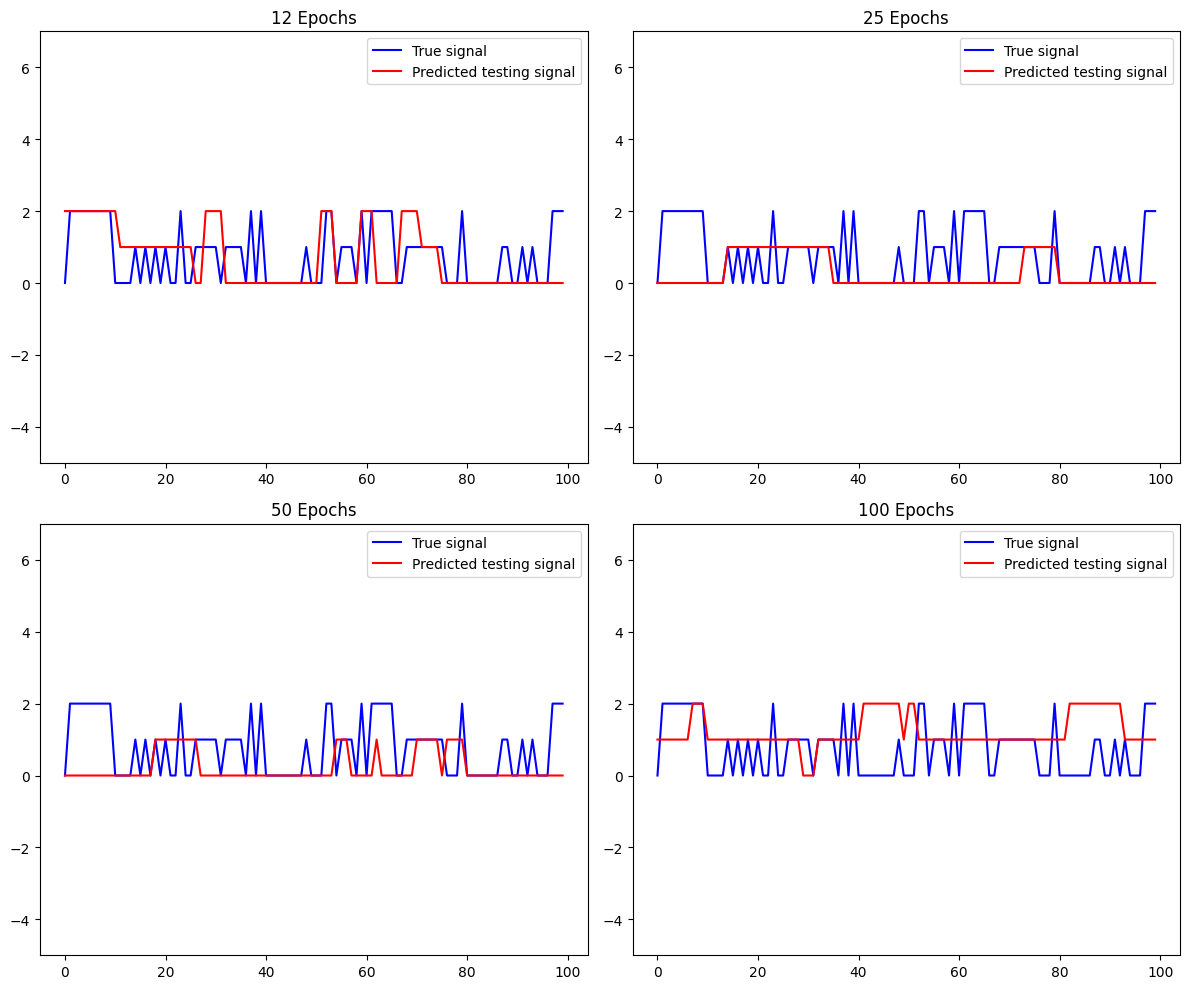

In [ ]:
# Plot results for the first 100 values with y-axis limits
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
epochs_subplot = zip(epochs_list, axes.flatten())

for epochs, ax in epochs_subplot:
    y_pred = results[epochs]["y_pred"][:100]
    ax.plot(y_test[:100], label="True signal", color='blue')
    ax.plot(y_pred, label="Predicted testing signal", color='red')
    # ax.set_title(f"Epochs: {epochs}, Loss: {results[epochs]['loss']:.4f}, Time: {results[epochs]['time']:.2f}s")
    ax.set_title(f"{epochs} Epochs")
    ax.set_ylim(-5, 7)  # Set y-axis limits
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Tìm số epoch có tổn thất nhỏ nhất (best model)
best_epochs = min(results, key=lambda x: results[x]['loss'])
best_loss = results[best_epochs]['loss']
best_time = results[best_epochs]['time']

print(f"Best model is from {best_epochs} epochs:")
print(f" - Loss: {best_loss:.4f}")
print(f" - Processing Time: {best_time:.2f} seconds")


Best model is from 50 epochs:
 - Loss: 1.0767
 - Processing Time: 46.91 seconds


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


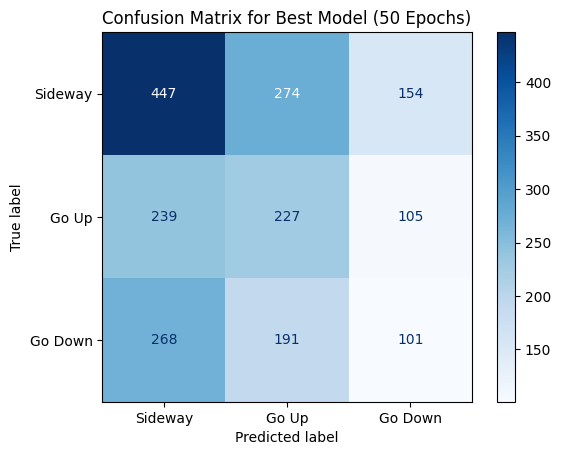

In [ ]:
# Tải lại mô hình tốt nhất (50 epochs)
best_model = results[12]["model"]

# Dự đoán trên tập kiểm tra (test set)
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)  # Chuyển sang nhãn 0, 1, 2

# Tính confusion matrix
cm = confusion_matrix(y_test[:len(y_test_pred_classes)], y_test_pred_classes)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sideway", "Go Up", "Go Down"]) # Đặt lại thứ tự nhãn để phù hợp với định nghĩa: 0 - Sideway, 1 - Go Up, 2 - Go Down

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix for Best Model (12 Epochs)")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Tạo báo cáo hiệu suất cho mô hình tốt nhất (12 epochs)
report = classification_report(y_test[:len(y_test_pred_classes)], y_test_pred_classes, target_names=["Sideway", "Go Up", "Go Down"])

# In báo cáo
print("Performance Metrics for Best Model (50 Epochs):")
print(report)

Performance Metrics for Best Model (50 Epochs):
              precision    recall  f1-score   support

     Sideway       0.47      0.51      0.49       875
       Go Up       0.33      0.40      0.36       571
     Go Down       0.28      0.18      0.22       560

    accuracy                           0.39      2006
   macro avg       0.36      0.36      0.36      2006
weighted avg       0.38      0.39      0.38      2006



In [ ]:
# Lưu mô hình lstm
best_model.save('lstm_model.h5')
print("Mô hình đã được lưu thành công!")

#### Prepare Data

In [ ]:
df.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_size_3,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,2284.01,2.32,2284.00,37.17,2284.02,0.10,2283.99,0.1,2284.10,1.56,...,2.13,2284.11,2.53,2283.89,9.49,2284.20,2.10,2283.88,15.10,1
2024-01-01 00:01:00,2285.89,12.41,2285.88,16.58,2285.91,18.93,2285.87,3.6,2285.93,0.30,...,2.97,2285.94,0.20,2285.79,5.08,2285.95,11.31,2285.76,18.96,1
2024-01-01 00:02:00,2286.29,33.21,2286.28,50.32,2286.30,0.11,2286.27,0.1,2286.34,0.22,...,5.50,2286.36,11.71,2286.24,8.02,2286.39,1.31,2286.23,22.86,1
2024-01-01 00:03:00,2288.31,1.31,2288.30,71.18,2288.32,0.10,2288.29,0.1,2288.33,30.56,...,15.00,2288.37,0.01,2288.25,2.00,2288.38,0.01,2288.24,18.74,1
2024-01-01 00:04:00,2289.98,26.53,2289.97,25.60,2289.99,33.31,2289.96,0.1,2290.00,34.27,...,10.31,2290.01,0.95,2289.89,3.60,2290.02,2.47,2289.88,11.67,1


https://www.math.fsu.edu/~aluffi/archive/paper462.pdf

In [ ]:
# time-insensitive set

# bid-ask spreads, mid-prices, and price differences (v2 and v3)
for level in range(1, 6):
    # v2
    # Spread calculation
    df[f"spread_{level}"] = df[f"ask_price_{level}"] - df[f"bid_price_{level}"]
    # Mid-price calculation
    df[f"midprice_{level}"] = (df[f"ask_price_{level}"] + df[f"bid_price_{level}"]) / 2.0

    # v3
    # Price differences from level 1
    if level > 1:
        df[f"ask_diff_{level}"] = df[f"ask_price_{level}"] - df["ask_price_1"]
        df[f"bid_diff_{level}"] = df["bid_price_1"] - df[f"bid_price_{level}"]

# Calculate average metrics
ask_prices = [f"ask_price_{i}" for i in range(1, 6)]
bid_prices = [f"bid_price_{i}" for i in range(1, 6)]
ask_vols = [f"ask_size_{i}" for i in range(1, 6)]
bid_vols = [f"bid_size_{i}" for i in range(1, 6)]

df["avg_ask_price"] = df[ask_prices].mean(axis=1).round(6)
df["avg_bid_price"] = df[bid_prices].mean(axis=1).round(6)
df["avg_ask_vol"] = df[ask_vols].mean(axis=1).round(6)
df["avg_bid_vol"] = df[bid_vols].mean(axis=1).round(6)

# Calculate accumulated differences
df["acc_price_diff"] = 0
df["acc_vol_diff"] = 0
for level in range(1, 6):
    df["acc_price_diff"] += (df[f"ask_price_{level}"] - df[f"bid_price_{level}"]).round(6)
    df["acc_vol_diff"] += (df[f"ask_size_{level}"] - df[f"bid_size_{level}"]).round(6)

In [ ]:
df = df.reset_index()

# time-sensitive set

# time difference (in seconds)
df["time_diff"] = df["timestamp"] - df["timestamp"].shift(time_span)
df["time_diff"] = df["time_diff"] / np.timedelta64(1, "s")

# price and volume derivatives (v6)
for level in range(1, 6):
    df[f"ask{level}_price_ddx"] = (
        (df[f"ask_price_{level}"] - df[f"ask_price_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"bid{level}_price_ddx"] = (
        (df[f"bid_price_{level}"] - df[f"bid_price_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"ask{level}_vol_ddx"] = (
        (df[f"ask_size_{level}"] - df[f"ask_size_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"ask{level}_vol_ddx"] = (
        (df[f"bid_size_{level}"] - df[f"bid_size_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)


In [ ]:
df = df.drop(columns=["timestamp", "time_diff"])
# first 5 rows that have null values will be dropped
df = df.dropna()

In [ ]:
# export file to fit SVM with different trials
df.to_csv('processed_orderbook_dfm.csv', index=False)

#### Fit SVM with Different Trials

In [ ]:
import trials_main
trials_main.run_file()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
trials_df = pd.read_csv('/content/Trials.csv')
trials_df.head(10)

,V1,V2,V3,V4,V5,V6,Accuracy,Precision,Recall,Time Taken
0,Y,N,N,N,N,N,0.3877,0.3845,0.3657,5.438285
1,N,Y,N,N,N,N,0.3847,0.3724,0.3727,6.800811
2,N,N,Y,N,N,N,0.3745,0.3678,0.3629,5.095467
3,N,N,N,Y,N,N,0.3884,0.3816,0.3687,3.875007
4,N,N,N,N,Y,N,0.3715,0.3711,0.3514,5.358988
5,N,N,N,N,N,Y,0.3824,0.3760,0.3602,6.078897
6,Y,Y,N,N,N,N,0.3817,0.3732,0.3575,7.362250
7,Y,N,Y,N,N,N,0.3652,0.2643,0.3370,7.758727
8,Y,N,N,Y,N,N,0.3880,0.3848,0.3666,5.690516
9,Y,N,N,N,Y,N,0.3897,0.4074,0.3684,7.607327


#### SVM model

In [ ]:
# List of basic order book features (prices and volumes for first 5 levels)
v1 = []
for level in range(1, 6):
    v1.extend([
        f"ask_price_{level}", f"ask_size_{level}",  # ask1_price  -->  ask_price_1
        f"bid_price_{level}", f"bid_size_{level}"    # ask1_vol  -->  ask_size_1
    ])

# Spread & Midprice
v2 = []
for level in range(1, 6):
    v2.append(f"spread_{level}")
    v2.append(f"midprice_{level}")

# Price differences from level 1
v3 = []
for level in range(2, 6):
    v3.append(f"ask_diff_{level}")
    v3.append(f"bid_diff_{level}")

# Calculate average metrics
v4 = ["avg_ask_price", "avg_bid_price", "avg_ask_vol", "avg_bid_vol"]

# Calculate accumulated differences
v5 = ["acc_price_diff", "acc_vol_diff"]

# price and volume derivatives (v6)
v6 = [
    "ask1_price_ddx",
    "bid1_price_ddx",
    "ask1_vol_ddx",
    "ask2_price_ddx",
    "bid2_price_ddx",
    "ask2_vol_ddx",
    "ask3_price_ddx",
    "bid3_price_ddx",
    "ask3_vol_ddx",
    "ask4_price_ddx",
    "bid4_price_ddx",
    "ask4_vol_ddx",
    "ask5_price_ddx",
    "bid5_price_ddx",
    "ask5_vol_ddx",
]


In [ ]:
def calculate_obp(df_ob, n, l):
    """
    Calculate the Order Book Pressure (OBP) for the DataFrame.

    Parameters:
    df_ob (pd.DataFrame): The input DataFrame containing bid and ask sizes.
    n (int): The number of historical snapshots to consider.
    l (int): The number of order book levels to include.

    Returns:
    pd.Series: A Series containing the OBP values for each timestamp.
    """
    obp_values = []

    # Iterate over each timestamp in the DataFrame
    for t in range(len(df_ob)):
        # Initialize sums
        total_bid_size = 0
        total_ask_size = 0

        # Calculate the sums for the last n snapshots and first l levels
        for tau in range(n + 1):
            if t - tau < 0:
                break  # Stop if we go out of bounds

            # Sum up the bid sizes for the first l levels
            for j in range(1, l + 1):
                total_bid_size += df_ob.iloc[t - tau][f'bid_size_{j}']

            # Sum up the ask sizes for the first l levels
            for i in range(1, l + 1):
                total_ask_size += df_ob.iloc[t - tau][f'ask_size_{i}']

        # Calculate OBP
        if total_ask_size > 0:  # Avoid division by zero
            obp = total_bid_size / total_ask_size
        else:
            obp = 0  # If there are no ask sizes, set OBP to 0

        obp_values.append(obp)

    return pd.Series(obp_values)

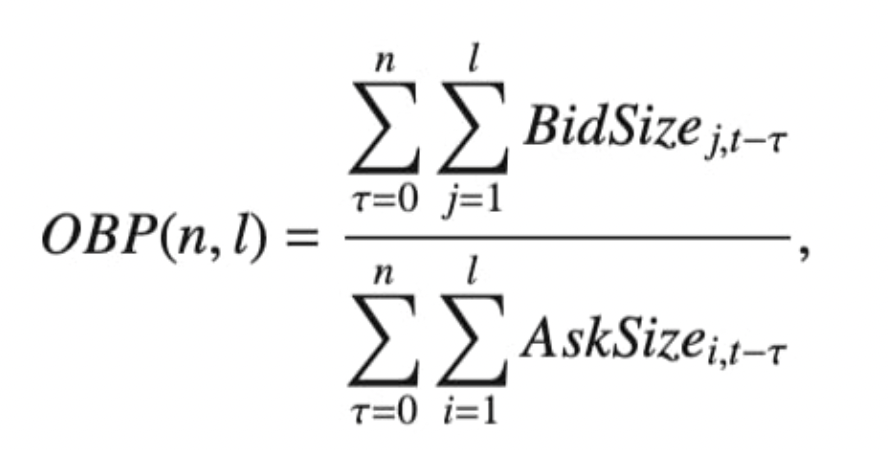

In [ ]:
n = 2  # Number of historical snapshots
l = 5  # Number of order book levels

# Calculate OBP
df['obp'] = calculate_obp(df, n, l).values

In [ ]:
metrics_df = pd.read_csv('/content/Trials.csv')
metrics_df.head(10)

,V1,V2,V3,V4,V5,V6,Accuracy,Precision,Recall,Time Taken
0,Y,N,N,N,N,N,0.3877,0.3845,0.3657,5.438285
1,N,Y,N,N,N,N,0.3847,0.3724,0.3727,6.800811
2,N,N,Y,N,N,N,0.3745,0.3678,0.3629,5.095467
3,N,N,N,Y,N,N,0.3884,0.3816,0.3687,3.875007
4,N,N,N,N,Y,N,0.3715,0.3711,0.3514,5.358988
5,N,N,N,N,N,Y,0.3824,0.3760,0.3602,6.078897
6,Y,Y,N,N,N,N,0.3817,0.3732,0.3575,7.362250
7,Y,N,Y,N,N,N,0.3652,0.2643,0.3370,7.758727
8,Y,N,N,Y,N,N,0.3880,0.3848,0.3666,5.690516
9,Y,N,N,N,Y,N,0.3897,0.4074,0.3684,7.607327


Chọn v4, v6 và obp để build model

In [ ]:
# # Load dataset
# df = pd.read_csv("/kaggle/working/orderbook_ETHUSDT_md.csv")
# df = pd.read_csv("processed_orderbook_dfm.csv")
# X = df.drop(columns=list(itertools.chain(v1, v2, v3, v4, v7, ['signal'])))  # Features

# Separate features and target
X = df.drop(columns=list(itertools.chain(v1, v2, v3, v4, ['signal'])))  # Features
y = df['signal']   # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01],
    'gamma': [0.01],
    'kernel': ['sigmoid']
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
svm = SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
# grid.fit(X_train_balanced, y_train_balanced)
grid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01], 'gamma': [0.01], 'kernel': ['sigmoid']},
             scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the model on test data
y_pred = grid.best_estimator_.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Parameters: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.06      0.11       749
           1       0.30      0.46      0.37       646
           2       0.30      0.44      0.35       621

    accuracy                           0.31      2016
   macro avg       0.35      0.32      0.28      2016
weighted avg       0.36      0.31      0.27      2016

Confusion Matrix:
[[ 47 368 334]
 [ 28 300 318]
 [ 29 318 274]]


In [ ]:
# Save the trained model
import pickle
model_path = "svm_model.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(grid.best_estimator_, model_file)
print(f"Model saved to {model_path}")

Model saved to svm_model.pkl


### Model for Order Book Signal

#### Prepare Data

In [ ]:
df = pd.read_csv('/content/orderbook_ETHUSDT_7d.csv', index_col=False)
df.head()

,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_2,ask_size_2,bid_price_2,bid_size_2,ask_price_3,ask_size_3,...,bid_size_3,ask_price_4,ask_size_4,bid_price_4,bid_size_4,ask_price_5,ask_size_5,bid_price_5,bid_size_5,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,2284.01,2.32,2284.00,37.17,2284.02,0.10,2283.99,0.1,2284.10,1.56,...,2.13,2284.11,2.53,2283.89,9.49,2284.20,2.10,2283.88,15.10,1
2024-01-01 00:01:00,2285.89,12.41,2285.88,16.58,2285.91,18.93,2285.87,3.6,2285.93,0.30,...,2.97,2285.94,0.20,2285.79,5.08,2285.95,11.31,2285.76,18.96,1
2024-01-01 00:02:00,2286.29,33.21,2286.28,50.32,2286.30,0.11,2286.27,0.1,2286.34,0.22,...,5.50,2286.36,11.71,2286.24,8.02,2286.39,1.31,2286.23,22.86,1
2024-01-01 00:03:00,2288.31,1.31,2288.30,71.18,2288.32,0.10,2288.29,0.1,2288.33,30.56,...,15.00,2288.37,0.01,2288.25,2.00,2288.38,0.01,2288.24,18.74,1
2024-01-01 00:04:00,2289.98,26.53,2289.97,25.60,2289.99,33.31,2289.96,0.1,2290.00,34.27,...,10.31,2290.01,0.95,2289.89,3.60,2290.02,2.47,2289.88,11.67,1


https://www.math.fsu.edu/~aluffi/archive/paper462.pdf

In [ ]:
# time-insensitive set

# bid-ask spreads, mid-prices, and price differences (v2 and v3)
for level in range(1, 6):
    # v2
    # Spread calculation
    df[f"spread_{level}"] = df[f"ask_price_{level}"] - df[f"bid_price_{level}"]
    # Mid-price calculation
    df[f"midprice_{level}"] = (df[f"ask_price_{level}"] + df[f"bid_price_{level}"]) / 2.0

    # v3
    # Price differences from level 1
    if level > 1:
        df[f"ask_diff_{level}"] = df[f"ask_price_{level}"] - df["ask_price_1"]
        df[f"bid_diff_{level}"] = df["bid_price_1"] - df[f"bid_price_{level}"]

# Calculate average metrics
ask_prices = [f"ask_price_{i}" for i in range(1, 6)]
bid_prices = [f"bid_price_{i}" for i in range(1, 6)]
ask_vols = [f"ask_size_{i}" for i in range(1, 6)]
bid_vols = [f"bid_size_{i}" for i in range(1, 6)]

df["avg_ask_price"] = df[ask_prices].mean(axis=1).round(6)
df["avg_bid_price"] = df[bid_prices].mean(axis=1).round(6)
df["avg_ask_vol"] = df[ask_vols].mean(axis=1).round(6)
df["avg_bid_vol"] = df[bid_vols].mean(axis=1).round(6)

# Calculate accumulated differences
df["acc_price_diff"] = 0
df["acc_vol_diff"] = 0
for level in range(1, 6):
    df["acc_price_diff"] += (df[f"ask_price_{level}"] - df[f"bid_price_{level}"]).round(6)
    df["acc_vol_diff"] += (df[f"ask_size_{level}"] - df[f"bid_size_{level}"]).round(6)

In [ ]:
df = df.reset_index()

# time-sensitive set

# time difference (in seconds)
df["time_diff"] = df["timestamp"] - df["timestamp"].shift(time_span)
df["time_diff"] = df["time_diff"] / np.timedelta64(1, "s")

# price and volume derivatives (v6)
for level in range(1, 6):
    df[f"ask{level}_price_ddx"] = (
        (df[f"ask_price_{level}"] - df[f"ask_price_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"bid{level}_price_ddx"] = (
        (df[f"bid_price_{level}"] - df[f"bid_price_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"ask{level}_vol_ddx"] = (
        (df[f"ask_size_{level}"] - df[f"ask_size_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)
    df[f"ask{level}_vol_ddx"] = (
        (df[f"bid_size_{level}"] - df[f"bid_size_{level}"].shift(time_span))
        / (df["time_diff"] / 60.0)
    ).round(6)


In [ ]:
df = df.drop(columns=["timestamp", "time_diff"])
# first 5 rows that have null values will be dropped
df = df.dropna()

In [ ]:
# export file to fit SVM with different trials
df.to_csv('processed_orderbook_dfm.csv', index=False)

#### Fit SVM with Different Trials

In [ ]:
import trials_main
trials_main.run_file()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
trials_df = pd.read_csv('/content/Trials.csv')
trials_df.head(10)

,V1,V2,V3,V4,V5,V6,Accuracy,Precision,Recall,Time Taken
0,Y,N,N,N,N,N,0.3877,0.3845,0.3657,5.438285
1,N,Y,N,N,N,N,0.3847,0.3724,0.3727,6.800811
2,N,N,Y,N,N,N,0.3745,0.3678,0.3629,5.095467
3,N,N,N,Y,N,N,0.3884,0.3816,0.3687,3.875007
4,N,N,N,N,Y,N,0.3715,0.3711,0.3514,5.358988
5,N,N,N,N,N,Y,0.3824,0.3760,0.3602,6.078897
6,Y,Y,N,N,N,N,0.3817,0.3732,0.3575,7.362250
7,Y,N,Y,N,N,N,0.3652,0.2643,0.3370,7.758727
8,Y,N,N,Y,N,N,0.3880,0.3848,0.3666,5.690516
9,Y,N,N,N,Y,N,0.3897,0.4074,0.3684,7.607327


#### SVM model

In [ ]:
# List of basic order book features (prices and volumes for first 5 levels)
v1 = []
for level in range(1, 6):
    v1.extend([
        f"ask_price_{level}", f"ask_size_{level}",  # ask1_price  -->  ask_price_1
        f"bid_price_{level}", f"bid_size_{level}"    # ask1_vol  -->  ask_size_1
    ])

# Spread & Midprice
v2 = []
for level in range(1, 6):
    v2.append(f"spread_{level}")
    v2.append(f"midprice_{level}")

# Price differences from level 1
v3 = []
for level in range(2, 6):
    v3.append(f"ask_diff_{level}")
    v3.append(f"bid_diff_{level}")

# Calculate average metrics
v4 = ["avg_ask_price", "avg_bid_price", "avg_ask_vol", "avg_bid_vol"]

# Calculate accumulated differences
v5 = ["acc_price_diff", "acc_vol_diff"]

# price and volume derivatives (v6)
v6 = [
    "ask1_price_ddx",
    "bid1_price_ddx",
    "ask1_vol_ddx",
    "ask2_price_ddx",
    "bid2_price_ddx",
    "ask2_vol_ddx",
    "ask3_price_ddx",
    "bid3_price_ddx",
    "ask3_vol_ddx",
    "ask4_price_ddx",
    "bid4_price_ddx",
    "ask4_vol_ddx",
    "ask5_price_ddx",
    "bid5_price_ddx",
    "ask5_vol_ddx",
]


In [ ]:
def calculate_obp(df_ob, n, l):
    """
    Calculate the Order Book Pressure (OBP) for the DataFrame.

    Parameters:
    df_ob (pd.DataFrame): The input DataFrame containing bid and ask sizes.
    n (int): The number of historical snapshots to consider.
    l (int): The number of order book levels to include.

    Returns:
    pd.Series: A Series containing the OBP values for each timestamp.
    """
    obp_values = []

    # Iterate over each timestamp in the DataFrame
    for t in range(len(df_ob)):
        # Initialize sums
        total_bid_size = 0
        total_ask_size = 0

        # Calculate the sums for the last n snapshots and first l levels
        for tau in range(n + 1):
            if t - tau < 0:
                break  # Stop if we go out of bounds

            # Sum up the bid sizes for the first l levels
            for j in range(1, l + 1):
                total_bid_size += df_ob.iloc[t - tau][f'bid_size_{j}']

            # Sum up the ask sizes for the first l levels
            for i in range(1, l + 1):
                total_ask_size += df_ob.iloc[t - tau][f'ask_size_{i}']

        # Calculate OBP
        if total_ask_size > 0:  # Avoid division by zero
            obp = total_bid_size / total_ask_size
        else:
            obp = 0  # If there are no ask sizes, set OBP to 0

        obp_values.append(obp)

    return pd.Series(obp_values)

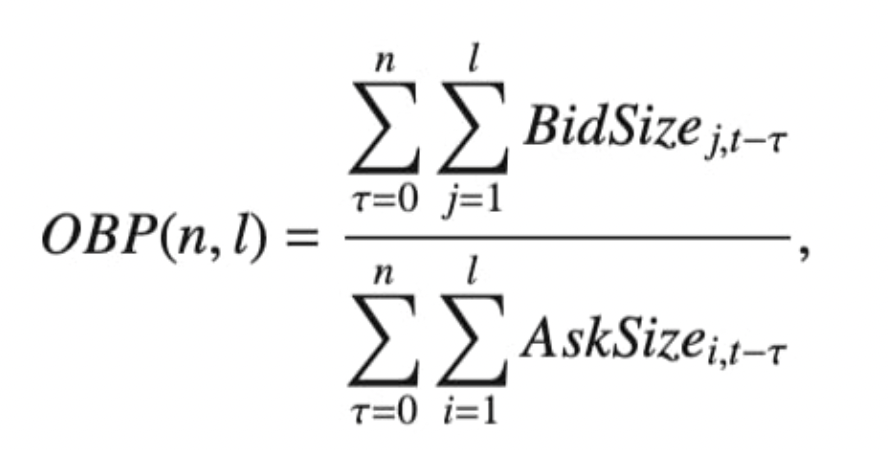

In [ ]:
n = 2  # Number of historical snapshots
l = 5  # Number of order book levels

# Calculate OBP
df['obp'] = calculate_obp(df, n, l).values

In [ ]:
metrics_df = pd.read_csv('/content/Trials.csv')
metrics_df.head(10)

,V1,V2,V3,V4,V5,V6,Accuracy,Precision,Recall,Time Taken
0,Y,N,N,N,N,N,0.3877,0.3845,0.3657,5.438285
1,N,Y,N,N,N,N,0.3847,0.3724,0.3727,6.800811
2,N,N,Y,N,N,N,0.3745,0.3678,0.3629,5.095467
3,N,N,N,Y,N,N,0.3884,0.3816,0.3687,3.875007
4,N,N,N,N,Y,N,0.3715,0.3711,0.3514,5.358988
5,N,N,N,N,N,Y,0.3824,0.3760,0.3602,6.078897
6,Y,Y,N,N,N,N,0.3817,0.3732,0.3575,7.362250
7,Y,N,Y,N,N,N,0.3652,0.2643,0.3370,7.758727
8,Y,N,N,Y,N,N,0.3880,0.3848,0.3666,5.690516
9,Y,N,N,N,Y,N,0.3897,0.4074,0.3684,7.607327


Chọn v4, v6 và obp để build model

In [ ]:
# # Save the processed dataset
# df['timestamp'] = df_ohc['start_at'][5:]
# df.to_csv("processed_orderbook_df.csv", index=False)

In [ ]:

# # Load dataset
# df = pd.read_csv("/kaggle/working/orderbook_ETHUSDT_md.csv")
# df = pd.read_csv("processed_orderbook_dfm.csv")
# X = df.drop(columns=list(itertools.chain(v1, v2, v3, v4, v7, ['signal'])))  # Features

# Separate features and target
X = df.drop(columns=list(itertools.chain(v1, v2, v3, v4, ['signal'])))  # Features
#X = df.drop(columns=['signal'] + columns_to_drop)
y = df['signal']   # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# # Handle class imbalance using SMOTE
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['sigmoid', 'rbf', 'linear']  # Kernel type
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
# grid.fit(X_train_balanced, y_train_balanced)
# grid.fit(X_train, y_train)
grid.fit(X_val, y_val)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['sigmoid', 'rbf', 'linear']},
             scoring='accuracy', verbose=2)

In [1]:
grid.best_params_

{'C': [0.01], 'gamma': [0.01], 'kernel': ['sigmoid']}

In [ ]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01],
    'gamma': [0.01],
    'kernel': ['sigmoid']
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
svm = SVC(probability=True)
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2, n_jobs=-1)
# grid.fit(X_train_balanced, y_train_balanced)
grid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01], 'gamma': [0.01], 'kernel': ['sigmoid']},
             scoring='accuracy', verbose=2)

In [ ]:
# Evaluate the model on test data
y_pred = grid.best_estimator_.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best Parameters: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.07      0.12       749
           1       0.30      0.46      0.36       646
           2       0.30      0.44      0.35       621

    accuracy                           0.31      2016
   macro avg       0.34      0.32      0.28      2016
weighted avg       0.35      0.31      0.27      2016

Confusion Matrix:
[[ 52 363 334]
 [ 34 295 317]
 [ 34 314 273]]


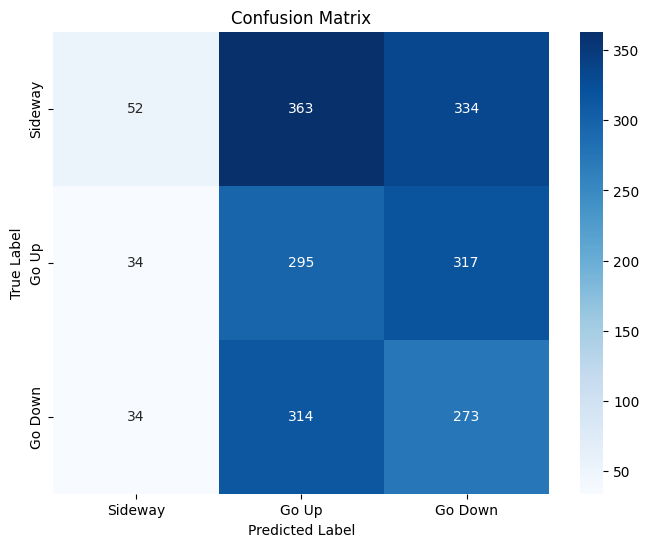

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Labels for the classes
class_labels = ["Sideway", "Go Up", "Go Down"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix with Best Parameters")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Save the trained model
import pickle
model_path = "svm_model.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(grid.best_estimator_, model_file)
print(f"Model saved to {model_path}")

Model saved to svm_model.pkl
